In [1]:
%reload_ext autoreload
%autoreload 1
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_manipulation_functions as dmf
import functions.plot_functions as pf
import seaborn as sns

%aimport functions.transformers
%aimport functions.data_manipulation_functions
%aimport functions.plot_functions

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [3]:
data_accepted=pl.read_csv('data/accepted_2007_to_2018Q4.csv',dtypes={'id':str})

In [4]:
data_accepted['id'].is_duplicated().any()

False

In [5]:
data_rejected=pl.read_csv('data/rejected_2007_to_2018Q4.csv')

In [6]:
data_rejected.shape

(27648741, 9)

In [7]:
data_accepted.shape

(2260701, 151)

In [8]:
integer_value = 42
float_value = pl.Float64(42)
string_value = "42"

print(f"Memory usage of integer: {sys.getsizeof(integer_value)} bytes")
print(f"Memory usage of float: {sys.getsizeof(float_value)} bytes")
print(f"Memory usage of string: {sys.getsizeof(string_value)} bytes")

Memory usage of integer: 28 bytes
Memory usage of float: 48 bytes
Memory usage of string: 51 bytes


In [9]:
data_rejected.head()

Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,str,f64,str,str,str,str,f64
1000.0,"""2007-05-26""","""Wedding Covere…",693.0,"""10%""","""481xx""","""NM""","""4 years""",0.0
1000.0,"""2007-05-26""","""Consolidating …",703.0,"""10%""","""010xx""","""MA""","""< 1 year""",0.0
11000.0,"""2007-05-27""","""Want to consol…",715.0,"""10%""","""212xx""","""MD""","""1 year""",0.0
6000.0,"""2007-05-27""","""waksman""",698.0,"""38.64%""","""017xx""","""MA""","""< 1 year""",0.0
1500.0,"""2007-05-27""","""mdrigo""",509.0,"""9.43%""","""209xx""","""MD""","""< 1 year""",0.0


### Join procedure

In [10]:
data_accepted = data_accepted.with_columns(pl.lit(np.int8(1)).alias('policy_code'))

In [11]:
data_rejected = data_rejected.with_columns(pl.lit(np.int8(0)).alias('Policy Code'))

In [12]:
data_rejected = data_rejected.with_columns(
    data_rejected["Debt-To-Income Ratio"]
    .map_elements(lambda x: np.float32(x.rstrip("%")))
    .alias("Debt-To-Income Ratio")
)

In [13]:
data_full = pl.concat(
    [
        data_rejected.select(
            pl.col("Amount Requested"),
            pl.col("Loan Title"),
            pl.col("Debt-To-Income Ratio"),
            pl.col("Zip Code"),
            pl.col("State"),
            pl.col("Employment Length"),
            pl.col("Policy Code"),
        ),
        data_accepted.select(
            pl.col('loan_amnt').alias("Amount Requested"),
            pl.col('title').alias("Loan Title"),
            pl.col('dti').alias("Debt-To-Income Ratio"),
            pl.col('zip_code').alias("Zip Code"),
            pl.col('addr_state').alias("State"),
            pl.col('emp_length').alias("Employment Length"),
            pl.col('policy_code').alias("Policy Code"),
        ),
    ]
)

In [14]:
data_full.null_count()

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
u32,u32,u32,u32,u32,u32,u32
33,24661,1744,327,55,1098295,0


In [15]:
data_full

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,f64,str,str,str,i32
1000.0,"""Wedding Covere…",10.0,"""481xx""","""NM""","""4 years""",0
1000.0,"""Consolidating …",10.0,"""010xx""","""MA""","""< 1 year""",0
11000.0,"""Want to consol…",10.0,"""212xx""","""MD""","""1 year""",0
6000.0,"""waksman""",38.639999,"""017xx""","""MA""","""< 1 year""",0
1500.0,"""mdrigo""",9.43,"""209xx""","""MD""","""< 1 year""",0
15000.0,"""Trinfiniti""",0.0,"""105xx""","""NY""","""3 years""",0
10000.0,"""NOTIFYi Inc""",10.0,"""210xx""","""MD""","""< 1 year""",0
3900.0,"""For Justin.""",10.0,"""469xx""","""IN""","""2 years""",0
3000.0,"""title?""",10.0,"""808xx""","""CO""","""4 years""",0


In [16]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    data_full.drop(columns=["Policy Code"]),
    data_full["Policy Code"],
    test_size=0.4,
    stratify=data_full["Policy Code"],
)

In [17]:
X_full_val, X_full_test, y_full_val, y_full_test = train_test_split(
    X_full_test, y_full_test, stratify=y_full_test, random_state=1
)

In [18]:
X_full_eda=X_full_train.clone()

In [19]:
len(data_full['Zip Code'].value_counts().filter(pl.col("counts")>10000))

641

In [20]:
X_full_eda=X_full_eda.with_columns(pl.col('Loan Title').str.to_lowercase().alias('Loan Title'))

In [21]:
X_full_eda=X_full_eda.with_columns(pl.col('Loan Title').str.replace(' ','_').alias('title_edited'))

In [22]:
# Define category-substring mappings
category_mappings = {
    "credit_card": ["credit_card"],
    "car": ["car"],
    "debt_consolidation": ["consolid", "refinan", "debt"],
    "medical": ["medic"],
    "business": ["business"],
    "moving": ["moving", "relocation"],
    "home": ["home", "house"],
    "education": ["educ", "school", "stud", "university"],
    "green_loan": ["renew"],
    # None: ["_", "other"]
}

category_mappings_is={None:["_","other"]}

X_full_eda=dmf.categorize_strings_contains(X_full_eda,category_mappings=category_mappings,col_name='title_edited')
X_full_eda=dmf.categorize_strings_is(X_full_eda,category_mappings=category_mappings_is,col_name='title_edited')



In [23]:
cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)

In [24]:
X_full_eda=X_full_eda.with_columns(
cat_imputer.fit_transform(X_full_eda['title_edited'])[:,0].alias('title_edited')
)


In [25]:
X_full_eda['title_edited'].value_counts().sort('counts')


title_edited,counts
str,u32
"""education""",6896
"""wedding""",11319
"""green_loan""",35052
"""vacation""",194280
"""moving""",430333
"""medical""",465570
"""business""",533365
"""major_purchase…",601591
"""home""",1220231


In [26]:
X_full_eda=X_full_eda.with_columns(
    pl.when(pl.col("Amount Requested") < 1)
    .then(None).otherwise(pl.col('Amount Requested')).alias("Amount Requested"))

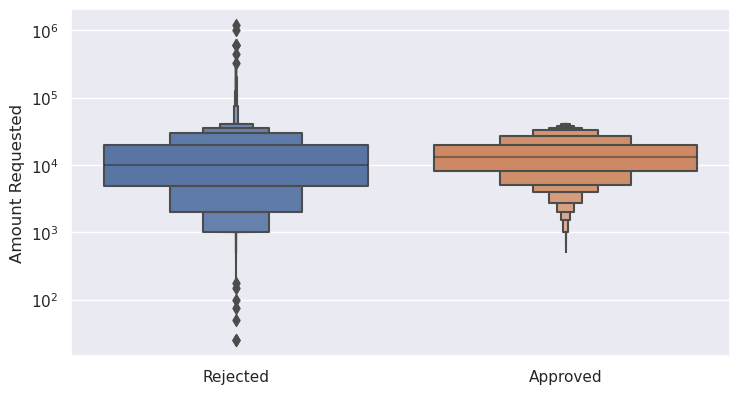

In [27]:
fig_requested_box, ax_requested_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxenplot(
    x=y_full_train.filter(X_full_eda["Amount Requested"].is_not_null()).to_numpy(),
    y=X_full_eda["Amount Requested"].drop_nulls().to_numpy(),
    ax=ax_requested_box
)
ax_requested_box.set_yscale("log")
ax_requested_box.set_ylabel("Amount Requested")
ax_requested_box.set_xticklabels(('Rejected','Approved'))
plt.show()

In [28]:
X_full_eda.null_count()

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,title_edited
u32,u32,u32,u32,u32,u32,u32
792,14698,1059,198,37,659343,3003918


##### Turn less than 0 into None

In [29]:
X_full_eda = X_full_eda.with_columns(
    pl.when(pl.col("Debt-To-Income Ratio") < 0)
    .then(None)
    .otherwise(pl.col("Debt-To-Income Ratio"))
    .alias("Debt-To-Income Ratio")
)

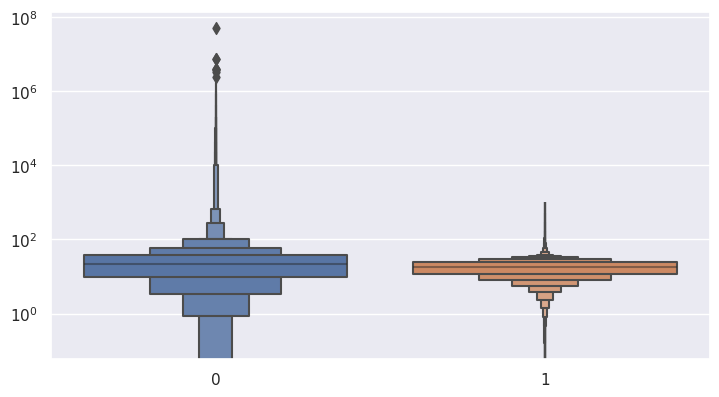

In [30]:
fig_dti_box, ax_dti_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxenplot(
    x=y_full_train.filter(X_full_eda["Debt-To-Income Ratio"].is_not_null()).to_numpy(),
    y=X_full_eda["Debt-To-Income Ratio"]
    .drop_nulls()
    .to_numpy(),

    ax=ax_dti_box
)

ax_dti_box.set_yscale("log")
plt.show()

In [31]:
dti_non_zero = (
    X_full_eda["Debt-To-Income Ratio"]
    .drop_nulls()
    .filter(X_full_eda["Debt-To-Income Ratio"].drop_nulls() != 0)
    .to_numpy()
)
dti_non_zero_y = y_full_train.filter(
    X_full_eda["Debt-To-Income Ratio"].is_not_null()
).filter(X_full_eda["Debt-To-Income Ratio"].drop_nulls() != 0)
dti_zero_x = (
    X_full_eda["Debt-To-Income Ratio"]
    .drop_nulls()
    .filter(X_full_eda["Debt-To-Income Ratio"].drop_nulls() == 0)
)
dti_zero_y = y_full_train.filter(
    X_full_eda["Debt-To-Income Ratio"].is_not_null()
).filter(X_full_eda["Debt-To-Income Ratio"].drop_nulls() == 0)

bins = dmf.create_bins((dti_non_zero), 50, log=True)

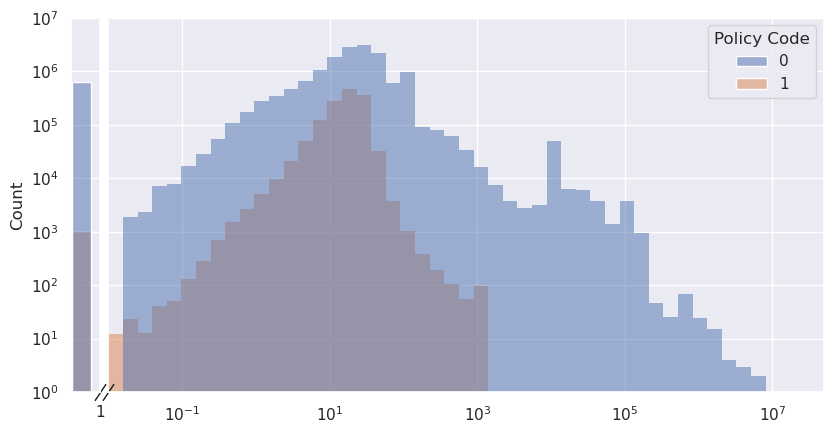

In [32]:
fig_dti_hist, ax_dti_hist = plt.subplots(
    1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 25]}, figsize=BASE_FIG_SIZE
)

sns.histplot(x=dti_non_zero, bins=bins, hue=dti_non_zero_y, ax=ax_dti_hist[1])
ax_dti_hist[1].set_xscale("log")
ax_dti_hist[1].set_yscale("log")
ax_dti_hist[1].set_ylim(1, 1e7)
ax_dti_hist[1].set_xlim(bins[0], bins[-1])
sns.histplot(
    x=dti_zero_x.to_numpy(),
    bins=1,
    hue=dti_zero_y.to_numpy(),
    ax=ax_dti_hist[0],
    legend=False,
)

pf.plot_x_axis_break(ax_dti_hist[0],ax_dti_hist[1])

ax_dti_hist[0].set_xticks([1])

plt.tight_layout(w_pad=-0.5)
plt.show()

##### Number of zip codes with more  than 50k values"

In [71]:
len(X_full_eda["Zip Code"].value_counts().sort("Zip Code").filter(
    X_full_eda["Zip Code"].value_counts().sort("Zip Code")['counts'] > 50000
))

86

In [72]:
zip_imputer=tr.NotInImputerPolars(cat_no=86,fill_value=None,)

In [73]:
X_full_eda=X_full_eda.with_columns(
zip_imputer.fit_transform(X_full_eda['Zip Code'])[:,0].alias('Zip Code')
)

In [95]:
X_full_eda["State"].value_counts().sort('counts')[-10:]["counts"].to_numpy(),

(array([ 555115,  561946,  651440,  655212,  674330,  695890, 1307954,
        1397702, 1608660, 2134590], dtype=uint32),)

In [289]:
state_counts=pl.DataFrame({'State':X_full_eda['State'],'accepted':y_full_train}).group_by('State').agg(
    pl.count().alias('Application Count'),
    (pl.sum('accepted')/pl.count()*100).alias('Accepted Percentage')
)

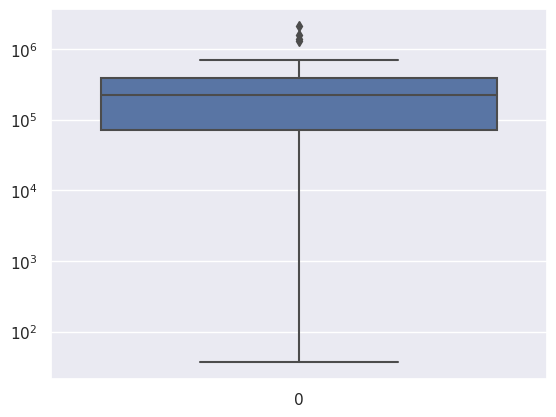

In [308]:
sns.boxplot(state_counts['Application Count'])
plt.yscale('log')

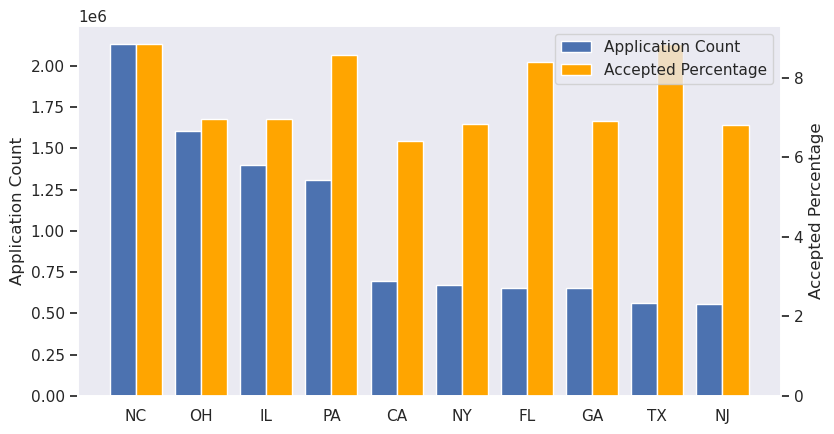

In [300]:
fig_state_counts, ax_state_counts = pf.plot_grouped_bars(
    state_counts, return_fig=True, top_vals=10,figsize_args={'figsize':BASE_FIG_SIZE}
)